# Retina Blood Vessel UNET


  Preparing metadata (setup.py) ... done


In [2]:
import os
import cv2
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import imantics
from PIL import Image
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from google.colab import drive
drive.mount('/gdrive')
%matplotlib inline

Mounted at /gdrive


In [3]:
images_dir ='/gdrive/MyDrive/dataset/Data/train/image'
masks_dir = '/gdrive/MyDrive/dataset/Data/train/mask'

In [4]:
images_listdir = os.listdir(images_dir)
masks_listdir = os.listdir(masks_dir)
random_images = np.random.choice(images_listdir, size = 9, replace = False)

In [5]:
print(len(images_listdir))
print(len(masks_listdir))

80
80


In [6]:
image_size=512
input_image_size=(512,512)

In [7]:
def read_image(path):
    img = cv2.imread(path)
    img = cv2.resize(img, (image_size, image_size))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [8]:
number=200

# Input images

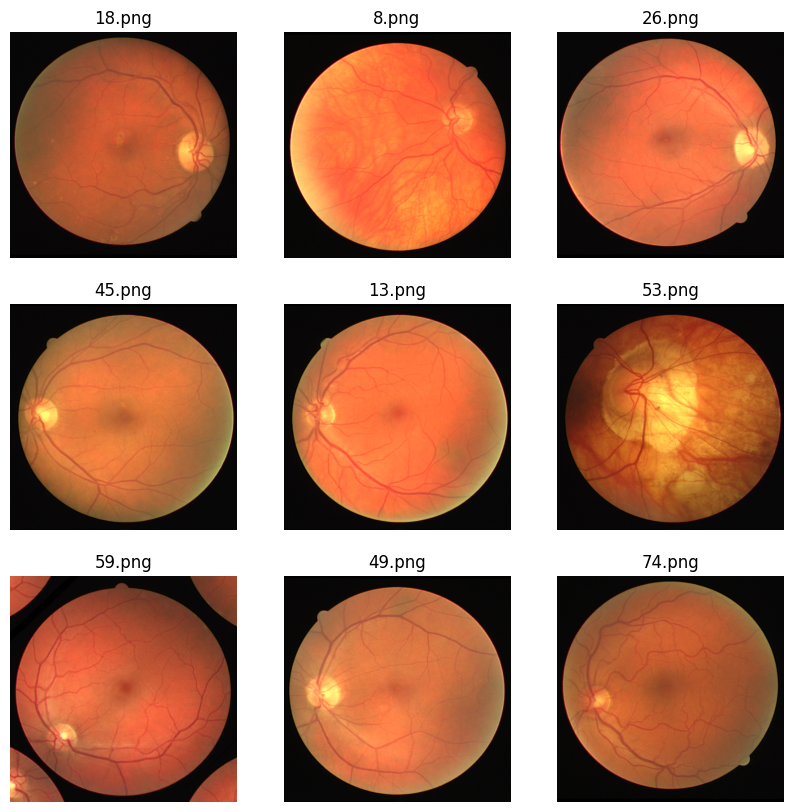

In [9]:
rows = 3
cols = 3
fig, ax = plt.subplots(rows, cols, figsize = (10,10))
for i, ax in enumerate(ax.flat):
    if i < len(random_images):
        img = read_image(f"{images_dir}/{random_images[i]}")
        ax.set_title(f"{random_images[i]}")
        ax.imshow(img)
        ax.axis('off')

# Ground truth masks

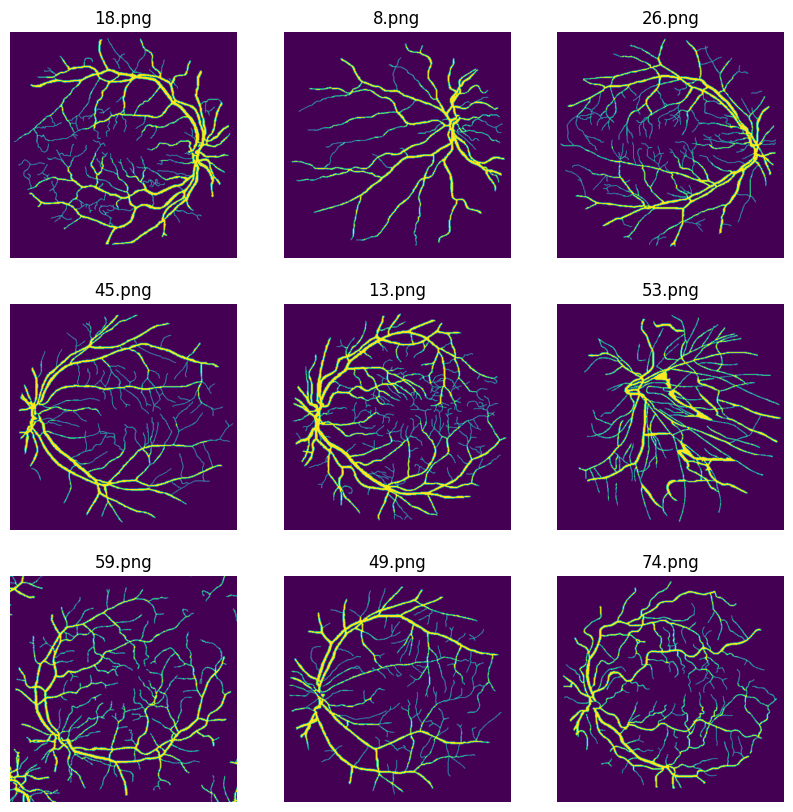

In [10]:
fig, ax = plt.subplots(rows, cols, figsize = (10,10))
for i, ax in enumerate(ax.flat):
    if i < len(random_images):
        file=random_images[i]
        if os.path.exists(os.path.join(masks_dir,file)):
            img = read_image(f"{masks_dir}/{file}")
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            ax.set_title(f"{random_images[i]}")
            ax.imshow(img)
            ax.axis('off')
        else:
            print('not exist')

In [11]:
MASKS=np.zeros((1,image_size, image_size, 1), dtype=bool)
IMAGES=np.zeros((1,image_size, image_size, 3),dtype=np.uint8)

for j,file in enumerate(images_listdir[0:number]):   ##the smaller, the faster
    try:
        image = read_image(f"{images_dir}/{file}")
        image_ex = np.expand_dims(image, axis=0)
        IMAGES = np.vstack([IMAGES, image_ex])
        mask = read_image(f"{masks_dir}/{file}")
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        mask = mask.reshape(512,512,1)
        mask_ex = np.expand_dims(mask, axis=0)
        MASKS = np.vstack([MASKS, mask_ex])
    except:
        print(file)
        continue

In [12]:
images=np.array(IMAGES)[1:number+1]
masks=np.array(MASKS)[1:number+1]
print(images.shape,masks.shape)

(80, 512, 512, 3) (80, 512, 512, 1)


In [13]:
images_train, images_test, masks_train, masks_test = train_test_split(
    images, masks, test_size=0.4, random_state=42)

In [14]:
print(len(images_train), len(masks_train))

48 48


# U-Net

In [15]:
def conv_block(input, num_filters):
    conv = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(input)
    conv = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Activation("relu")(conv)
    conv = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(conv)
    conv = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Activation("relu")(conv)
    return conv

def encoder_block(input, num_filters):
    skip = conv_block(input, num_filters)
    pool = tf.keras.layers.MaxPool2D((2,2))(skip)
    return skip, pool

def decoder_block(input, skip, num_filters):
    up_conv = tf.keras.layers.Conv2DTranspose(num_filters, (2,2), strides=2, padding="same")(input)
    conv = tf.keras.layers.Concatenate()([up_conv, skip])
    conv = conv_block(conv, num_filters)
    return conv

def Unet(input_shape):
    inputs = tf.keras.layers.Input(input_shape)

    skip1, pool1 = encoder_block(inputs, 64)
    skip2, pool2 = encoder_block(pool1, 128)
    skip3, pool3 = encoder_block(pool2, 256)
    skip4, pool4 = encoder_block(pool3, 512)

    bridge = conv_block(pool4, 1024)

    decode1 = decoder_block(bridge, skip4, 512)
    decode2 = decoder_block(decode1, skip3, 256)
    decode3 = decoder_block(decode2, skip2, 128)
    decode4 = decoder_block(decode3, skip1, 64)
    outputs = tf.keras.layers.Conv2D(1, 1, padding="same", activation="sigmoid")(decode4)
    model = tf.keras.models.Model(inputs, outputs, name="U-Net")
    return model

unet_model = Unet((512,512,3))
unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [16]:
unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 512, 512, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 512, 512, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 512, 512, 64)         0         ['batch_normalization[0][0

# Train
Suitable number epoch range is narrow.

In [17]:
history = unet_model.fit(
    images_train, masks_train,
    validation_split = 0.2, batch_size = 4, epochs = 20)

Epoch 1/20
10/10 [==============================] - 62s 2s/step - loss: -175.9692 - accuracy: 0.4506 - val_loss: -326262.5625 - val_accuracy: 6.4163e-04
Epoch 2/20
10/10 [==============================] - 10s 1s/step - loss: -311.8358 - accuracy: 0.5744 - val_loss: -2112196.7500 - val_accuracy: 5.7335e-04
Epoch 3/20
10/10 [==============================] - 10s 1s/step - loss: -370.9459 - accuracy: 0.3365 - val_loss: -937510.3125 - val_accuracy: 5.7335e-04
Epoch 4/20
10/10 [==============================] - 10s 1s/step - loss: -408.8138 - accuracy: 0.3250 - val_loss: -65529.9180 - val_accuracy: 5.7335e-04
Epoch 5/20
10/10 [==============================] - 11s 1s/step - loss: -444.4618 - accuracy: 0.3239 - val_loss: -4779.5356 - val_accuracy: 5.9090e-04
Epoch 6/20
10/10 [==============================] - 11s 1s/step - loss: -478.5127 - accuracy: 0.3182 - val_loss: -8168.8701 - val_accuracy: 5.8098e-04
Epoch 7/20
10/10 [==============================] - 10s 1s/step - loss: -508.8104 - ac

# Predict valid images

In [19]:
def show_result(idx, og, unet, target, p):

    fig, axs = plt.subplots(1, 3, figsize=(12,12))
    axs[0].set_title("Original "+str(idx) )
    axs[0].imshow(og)
    axs[0].axis('off')

    axs[1].set_title("U-Net: p>"+str(p))
    axs[1].imshow(unet)
    axs[1].axis('off')

    axs[2].set_title("Ground Truth")
    axs[2].imshow(target)
    axs[2].axis('off')

    plt.show()

In [20]:
unet_predict = unet_model.predict(images_test[:4])

1/1 [==============================] - 0s 398ms/step


In [21]:
len(images_test)

32

In [22]:
r1,r2,r3,r4=0.7,0.8,0.9,0.99

In [23]:
unet_predict1 = (unet_predict > r1).astype(np.uint8)
unet_predict2 = (unet_predict > r2).astype(np.uint8)
unet_predict3 = (unet_predict > r3).astype(np.uint8)
unet_predict4 = (unet_predict > r4).astype(np.uint8)

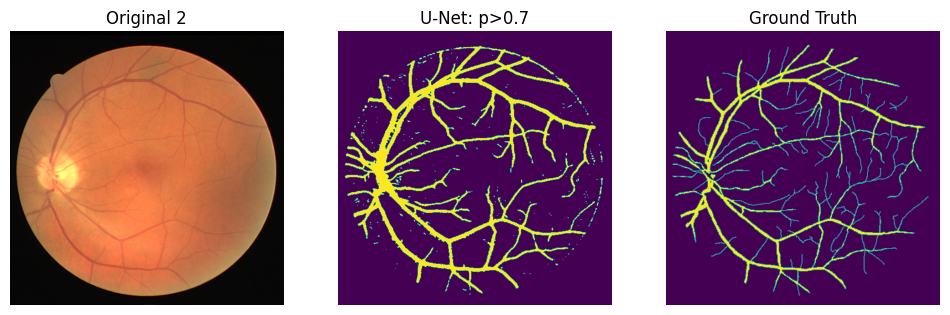

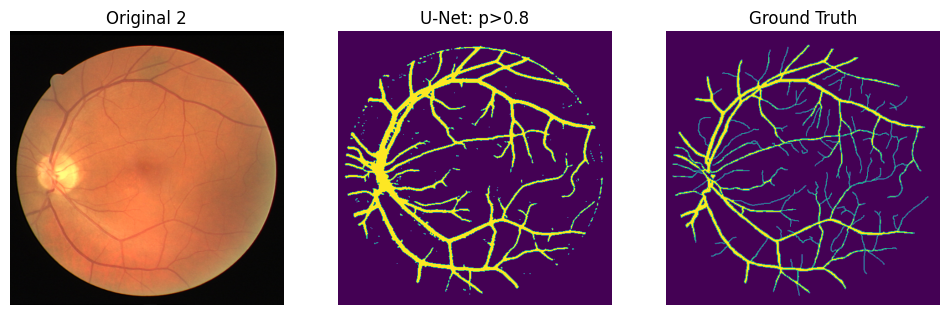

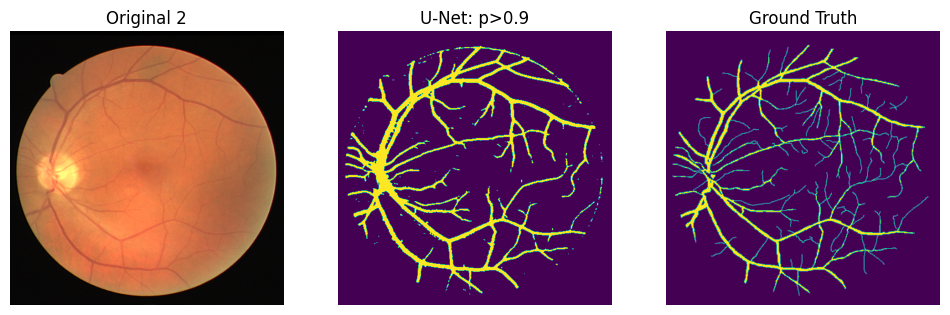

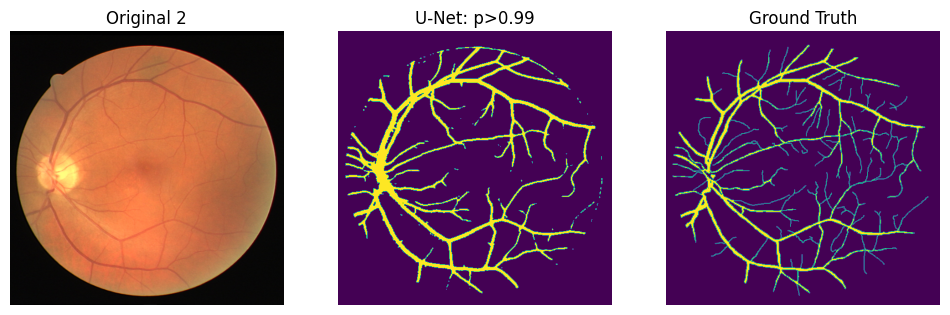

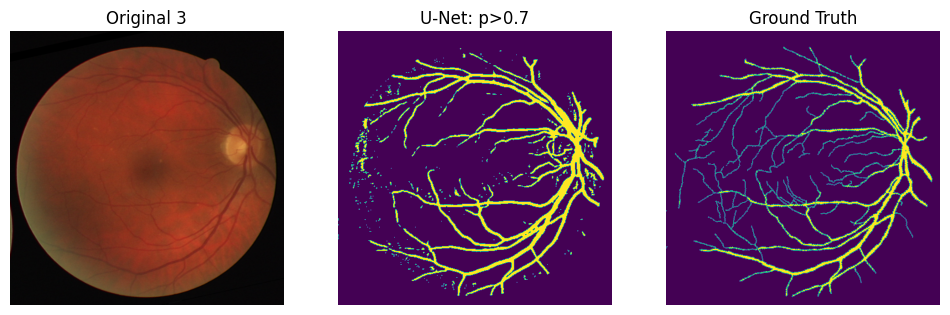

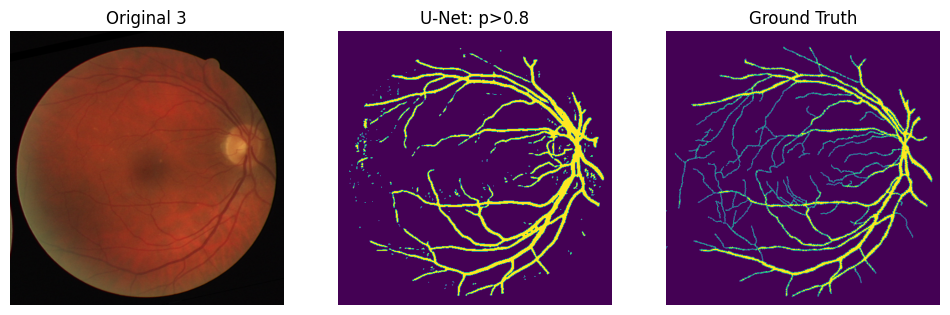

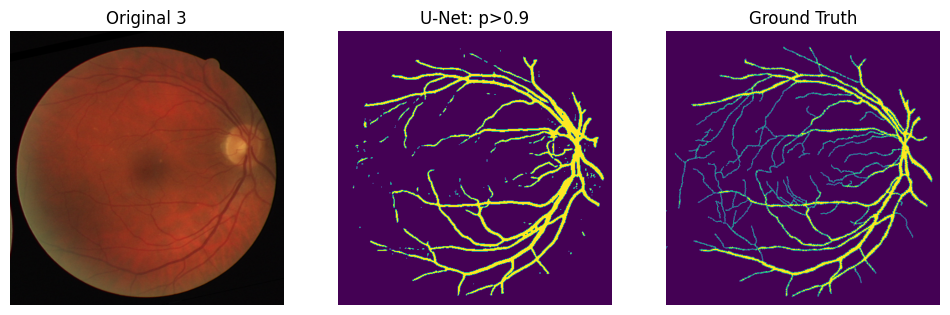

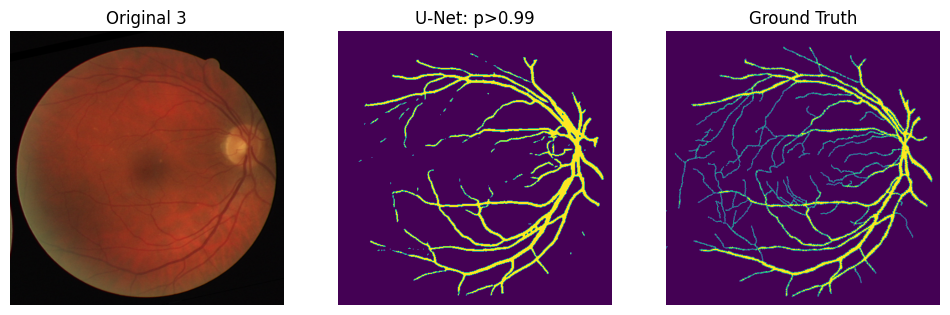

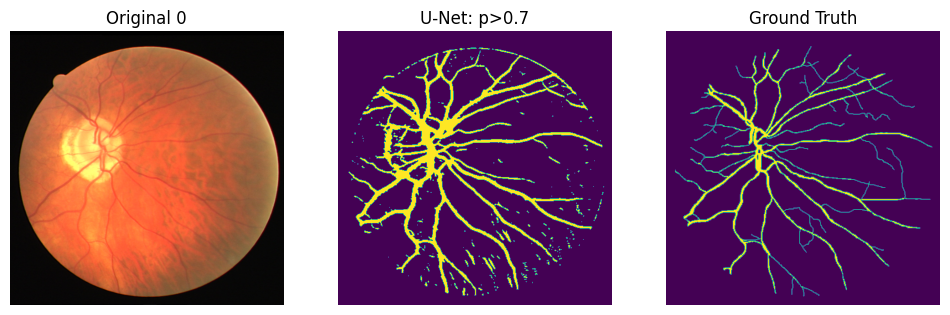

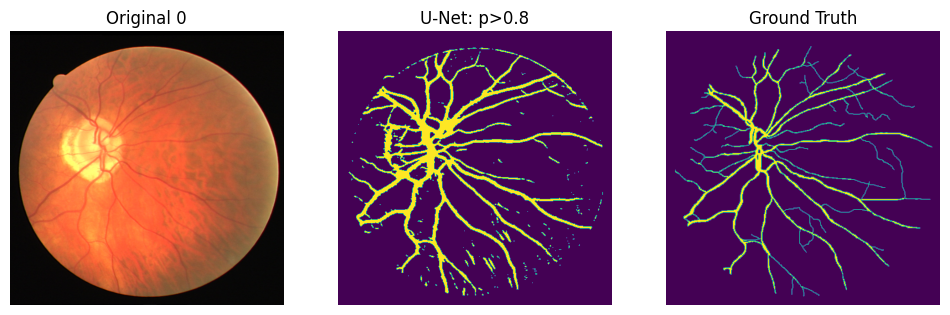

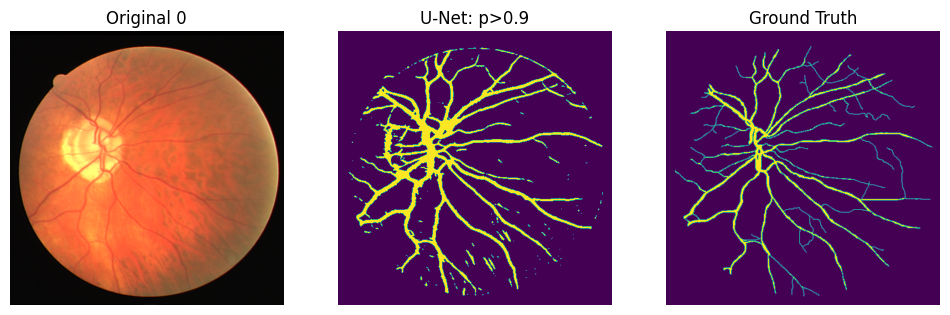

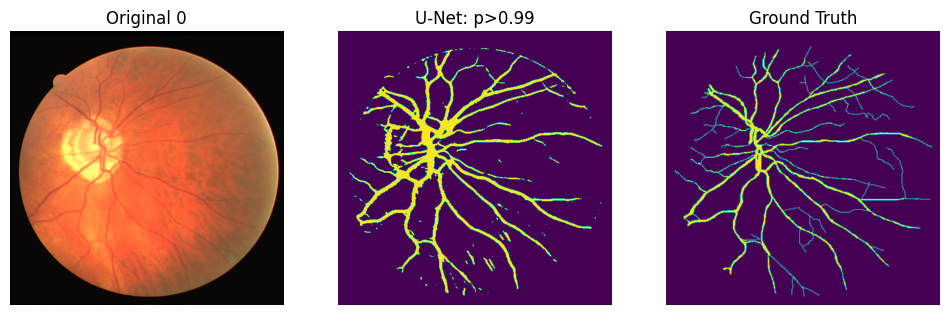

In [24]:
show_test_idx = random.sample(range(len(unet_predict)), 3)
for idx in show_test_idx:
    show_result(idx, images_test[idx], unet_predict1[idx], masks_test[idx], r1)
    show_result(idx, images_test[idx], unet_predict2[idx], masks_test[idx], r2)
    show_result(idx, images_test[idx], unet_predict3[idx], masks_test[idx], r3)
    show_result(idx, images_test[idx], unet_predict4[idx], masks_test[idx], r4)
    print()

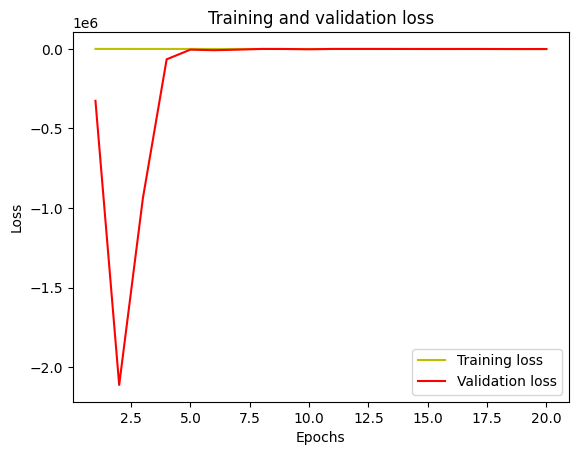

In [25]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

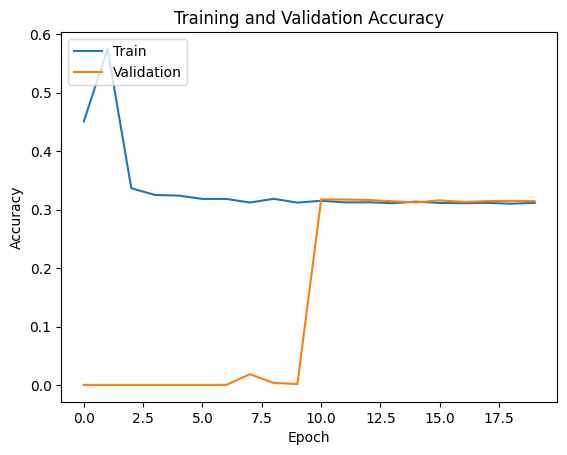

In [26]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()